In [2]:
!pip install facenet-pytorch opencv-python

INFO: pip is looking at multiple versions of opencv-python to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.0 MB 12.7 MB/s eta 0:00:00
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.13.0.90
    Uninstalling opencv-python-4.13.0.90:
      Successfully uninstalled opencv-python-4.13.0.90


In [3]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os
import glob
import matplotlib.pyplot as plt

# --- 1. Download from Udacity Mirror (Bypassing Google Drive Quota) ---
print("Downloading CelebA from Udacity Mirror...")

# Check if file already exists to avoid re-downloading
if not os.path.exists('celeba.zip'):
    # Using wget to download from a stable mirror
    !wget -q https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/celeba.zip
    print("Download completed.")
else:
    print("Zip file already exists.")

# Unzip the file
if not os.path.exists('./celeba'):
    print("Unzipping data... (This might take a minute)")
    !unzip -q celeba.zip
    # !unzip -n celebA_data.zip
    print("Unzip completed.")
else:
    print("Data already unzipped.")

# --- 2. Create Custom Dataset Class ---
# Since we downloaded manually, we need a simple class to load images
class CustomCelebA(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        # Get all .jpg files in the directory
        # The Udacity zip structure is usually celeba/img_align_celeba/*.jpg
        self.image_paths = glob.glob(os.path.join(root_dir, '*.jpg'))

        # Verify if images were found
        if len(self.image_paths) == 0:
             # Try checking subfolder if structure is slightly different
             self.image_paths = glob.glob(os.path.join(root_dir, 'img_align_celeba', '*.jpg'))

        print(f"Found {len(self.image_paths)} images.")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        # Return image and a dummy label (0) since we don't need labels for restoration
        return image, 0

# --- 3. Setup DataLoader ---
BATCH_SIZE = 16
IMAGE_SIZE = 128

# Define transforms
transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
])

# Initialize Dataset
# Note: Pointing to the extracted folder
data_path = './celeba'
# If unzip created a subfolder 'img_align_celeba' inside 'celeba', the class handles it.
train_dataset = CustomCelebA(root_dir=data_path, transform=transform)

if len(train_dataset) > 0:
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    print("Dataset loaded successfully from Mirror!")

    # --- 4. Verify & Visualize ---
    dataiter = iter(train_loader)
    images, _ = next(dataiter)

    plt.figure(figsize=(10, 5))
    for i in range(8):
        ax = plt.subplot(2, 4, i + 1)
        img_np = images[i].permute(1, 2, 0).numpy()
        plt.imshow(img_np)
        plt.axis('off')
        plt.title(f"Sample {i+1}")
    plt.show()

else:
    print("Error: No images found. Check the unzip path.")

Download completed.
Unzipping data... (This might take a minute)
Unzip completed.
Found 0 images.
Error: No images found. Check the unzip path.


Searching for images starting from: /content
Found images in: ./img_align_celeba
Target data directory set to: ./img_align_celeba
Dataset initialized. Found 202599 images.
Batch shape: torch.Size([16, 3, 128, 128])


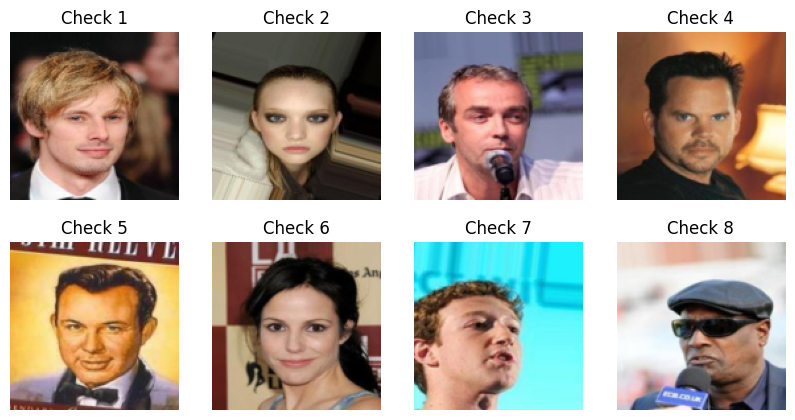

Success! Dataset is ready for Alignment (Step 2).


In [4]:
import os
import glob
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

# --- 1. Find the Correct Image Directory ---
def find_image_directory(start_path='.'):
    print(f"Searching for images starting from: {os.path.abspath(start_path)}")
    # We look for a folder that contains at least one .jpg file
    for root, dirs, files in os.walk(start_path):
        for file in files:
            if file.endswith(".jpg") or file.endswith(".png"):
                print(f"Found images in: {root}")
                return root
    return None

# Locate the folder containing the images
data_path = find_image_directory('.')

if data_path is None:
    print("Critical Error: Could not find any images. Please check if the unzip step actually worked.")
else:
    print(f"Target data directory set to: {data_path}")

    # --- 2. Define Custom Dataset Class ---
    class CustomCelebA(Dataset):
        def __init__(self, root_dir, transform=None):
            self.root_dir = root_dir
            self.transform = transform
            # Load all jpg files from the discovered directory
            self.image_paths = glob.glob(os.path.join(root_dir, '*.jpg'))
            print(f"Dataset initialized. Found {len(self.image_paths)} images.")

        def __len__(self):
            return len(self.image_paths)

        def __getitem__(self, idx):
            img_path = self.image_paths[idx]
            # Convert to RGB to ensure 3 channels
            image = Image.open(img_path).convert("RGB")

            if self.transform:
                image = self.transform(image)

            return image, 0 # Return 0 as dummy label

    # --- 3. Setup DataLoader ---
    BATCH_SIZE = 16
    IMAGE_SIZE = 128

    transform = transforms.Compose([
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.ToTensor(),
    ])

    # Initialize Dataset with the CORRECT path found above
    train_dataset = CustomCelebA(root_dir=data_path, transform=transform)

    # Create DataLoader
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

    # --- 4. Verify & Visualize ---
    # Get a batch of images
    dataiter = iter(train_loader)
    images, _ = next(dataiter)

    print(f"Batch shape: {images.shape}") # Expect: [16, 3, 128, 128]

    # Plot images
    plt.figure(figsize=(10, 5))
    for i in range(8):
        ax = plt.subplot(2, 4, i + 1)
        # Permute from (C, H, W) to (H, W, C) for matplotlib
        img_np = images[i].permute(1, 2, 0).numpy()
        plt.imshow(img_np)
        plt.axis('off')
        plt.title(f"Check {i+1}")
    plt.show()

    print("Success! Dataset is ready for Alignment (Step 2).")

In [5]:
import os
import random
import numpy as np
import cv2
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision.transforms.functional as F
from PIL import Image
import matplotlib.pyplot as plt

# --- Configuration ---
CONFIG = {
    'downsample_factors': [1.2, 1.4],     # PDF Section 3 requirements
    'noise_sigma_range': [0.02, 0.05],    # Gaussian Noise sigma range
    'blur_kernel_sizes': [3, 5, 7],       # Bonus Task: Kernel sizes for Motion Blur
    'img_size': 128
}

class CelebARestorationDataset(Dataset):
    def __init__(self, root_dir, transform=None, mode='train'):
        self.root_dir = root_dir
        # Recursively find all image paths to avoid directory issues
        self.image_paths = []
        for root, _, files in os.walk(root_dir):
            for file in files:
                if file.endswith(('.jpg', '.jpeg', '.png')):
                    self.image_paths.append(os.path.join(root, file))

        self.transform = transform
        self.mode = mode

        # Augmentation pipeline for HQ images (Training only) - PDF Section 2
        self.augment_transform = transforms.Compose([
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.ColorJitter(brightness=0.2, contrast=0.2)
        ])

    def apply_motion_blur(self, img_tensor):
        """
        BONUS TASK 2: Implementation of Motion Blur Degradation.
        Creates a linear kernel and convolves it with the image.
        """
        # Convert tensor (C, H, W) to numpy (H, W, C) for OpenCV
        img_np = img_tensor.permute(1, 2, 0).numpy()

        # Randomly select kernel size
        k_size = random.choice(CONFIG['blur_kernel_sizes'])

        # Create a blank kernel
        kernel = np.zeros((k_size, k_size))

        # Randomly choose direction: Horizontal, Vertical, or Diagonal
        direction = random.choice(['h', 'v', 'd'])
        if direction == 'h':
            kernel[int((k_size-1)/2), :] = np.ones(k_size)
        elif direction == 'v':
            kernel[:, int((k_size-1)/2)] = np.ones(k_size)
        else:
            # Diagonal motion blur
            np.fill_diagonal(kernel, 1)

        # Normalize the kernel so the image brightness doesn't change
        kernel /= kernel.sum()

        # Apply the filter
        blurred = cv2.filter2D(img_np, -1, kernel)

        # Convert back to torch tensor
        return torch.from_numpy(blurred).float().permute(2, 0, 1)

    def apply_downsampling(self, img_tensor):
        """
        PDF Section 3: Downsample by a factor, then Upsample back.
        """
        factor = random.choice(CONFIG['downsample_factors'])
        c, h, w = img_tensor.shape

        # Calculate new dimensions
        new_h, new_w = int(h / factor), int(w / factor)

        # Downsample (Bilinear)
        small_img = F.resize(img_tensor, [new_h, new_w], interpolation=transforms.InterpolationMode.BILINEAR)

        # Upsample back to original size (Bicubic)
        restored_size_img = F.resize(small_img, [h, w], interpolation=transforms.InterpolationMode.BICUBIC)

        return restored_size_img

    def apply_gaussian_noise(self, img_tensor):
        """
        PDF Section 3: Add Gaussian Noise.
        """
        sigma = random.uniform(*CONFIG['noise_sigma_range'])
        noise = torch.randn_like(img_tensor) * sigma
        noisy_img = img_tensor + noise
        return torch.clamp(noisy_img, 0., 1.)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")

        # 1. Prepare Target (High Quality)
        if self.transform:
            hq_image = self.transform(image)

        # 2. Apply Augmentations (Only in Training mode)
        if self.mode == 'train':
            hq_image = self.augment_transform(hq_image)

        # 3. Create Input (Low Quality) - Randomly select degradation type
        # 33% Downsampling, 33% Noise, 34% Motion Blur (Bonus)
        degradation_choice = random.random()
        lq_image = hq_image.clone()

        if degradation_choice < 0.33:
            lq_image = self.apply_downsampling(lq_image)
        elif degradation_choice < 0.66:
            lq_image = self.apply_gaussian_noise(lq_image)
        else:
            # Apply Bonus Task: Motion Blur
            lq_image = self.apply_motion_blur(lq_image)

        return lq_image, hq_image

# --- Setup DataLoaders ---
base_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

# Assuming 'data_path' is defined in previous cells
full_dataset = CelebARestorationDataset(root_dir=data_path, transform=base_transform, mode='train')

# Split dataset: 90% Training, 10% Validation
train_size = int(0.9 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_set, val_set = torch.utils.data.random_split(full_dataset, [train_size, val_size])

train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = DataLoader(val_set, batch_size=32, shuffle=False)

print("Dataset initialized with Bonus Tasks (Motion Blur).")


Dataset initialized with Bonus Tasks (Motion Blur).


Running MTCNN on device: cuda
Applying alignment to a sample batch...


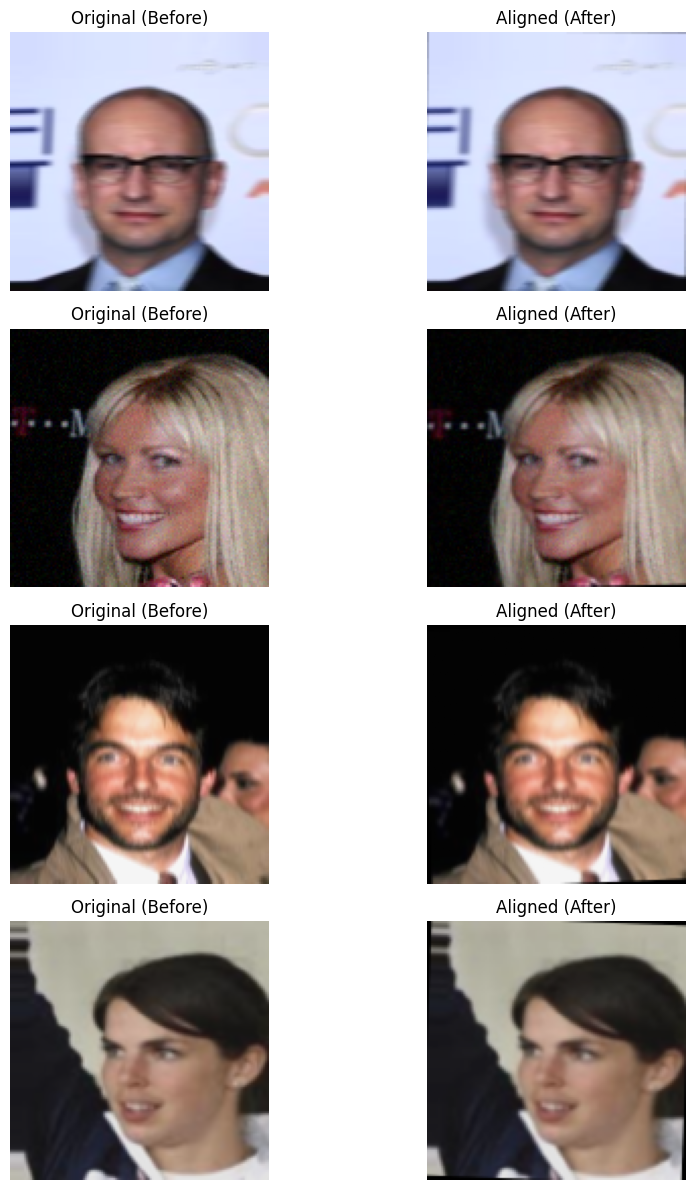

In [6]:
# --- 1. Install Face Detection Library ---
# We use facenet-pytorch for easy access to MTCNN

import torch
import numpy as np
import cv2
from facenet_pytorch import MTCNN
from PIL import Image
import matplotlib.pyplot as plt

# --- 2. Initialize MTCNN Model ---
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Running MTCNN on device: {device}")

# keep_all=False: we only want the main face
# select_largest=True: if multiple faces, pick the biggest one
mtcnn = MTCNN(keep_all=False, select_largest=True, device=device)

# --- 3. Define Alignment Function ---
def align_face_custom(image_tensor):
    """
    Takes a tensor image (C, H, W), detects face landmarks,
    calculates the angle between eyes, and rotates the image.
    """
    # Convert PyTorch Tensor to Numpy (H, W, C) for OpenCV/MTCNN
    # Expecting input range [0, 1], convert to [0, 255]
    img_np = image_tensor.permute(1, 2, 0).numpy() * 255
    img_np = img_np.astype(np.uint8)

    # MTCNN expects PIL image
    img_pil = Image.fromarray(img_np)

    try:
        # Detect boxes and landmarks
        boxes, probs, landmarks = mtcnn.detect(img_pil, landmarks=True)

        # If no face is detected, return original
        if landmarks is None:
            return image_tensor

        # Get landmarks for the first detected face
        # landmarks format: [left_eye, right_eye, nose, left_mouth, right_mouth]
        left_eye = landmarks[0][0]
        right_eye = landmarks[0][1]

        # Calculate angle between eyes
        # dy = y2 - y1, dx = x2 - x1
        dy = right_eye[1] - left_eye[1]
        dx = right_eye[0] - left_eye[0]
        angle = np.degrees(np.arctan2(dy, dx))

        # Calculate center of the image for rotation
        center = (img_np.shape[1] // 2, img_np.shape[0] // 2)

        # Create Rotation Matrix
        M = cv2.getRotationMatrix2D(center, angle, 1.0)

        # Apply rotation (warpAffine)
        aligned_img_np = cv2.warpAffine(img_np, M, (img_np.shape[1], img_np.shape[0]))

        # Convert back to Tensor (C, H, W) and range [0, 1]
        aligned_tensor = torch.from_numpy(aligned_img_np).permute(2, 0, 1).float() / 255.0

        return aligned_tensor

    except Exception as e:
        # In case of any error, return original
        # print(f"Alignment warning: {e}")
        return image_tensor

# --- 4. Apply to a Batch and Visualize ---
print("Applying alignment to a sample batch...")

# Get a batch from the previously loaded 'train_loader'
dataiter = iter(train_loader)
images, _ = next(dataiter)

# Visualize Before vs After
plt.figure(figsize=(10, 12))

# We will show 4 samples
num_samples = 4
for i in range(num_samples):
    original = images[i]
    aligned = align_face_custom(original)

    # Plot Original
    ax = plt.subplot(num_samples, 2, 2*i + 1)
    plt.imshow(original.permute(1, 2, 0))
    plt.title("Original (Before)")
    plt.axis('off')

    # Plot Aligned
    ax = plt.subplot(num_samples, 2, 2*i + 2)
    plt.imshow(aligned.permute(1, 2, 0))
    plt.title("Aligned (After)")
    plt.axis('off')

plt.tight_layout()
plt.show()

Total images: 202599
Train size: 182339, Validation size: 20260


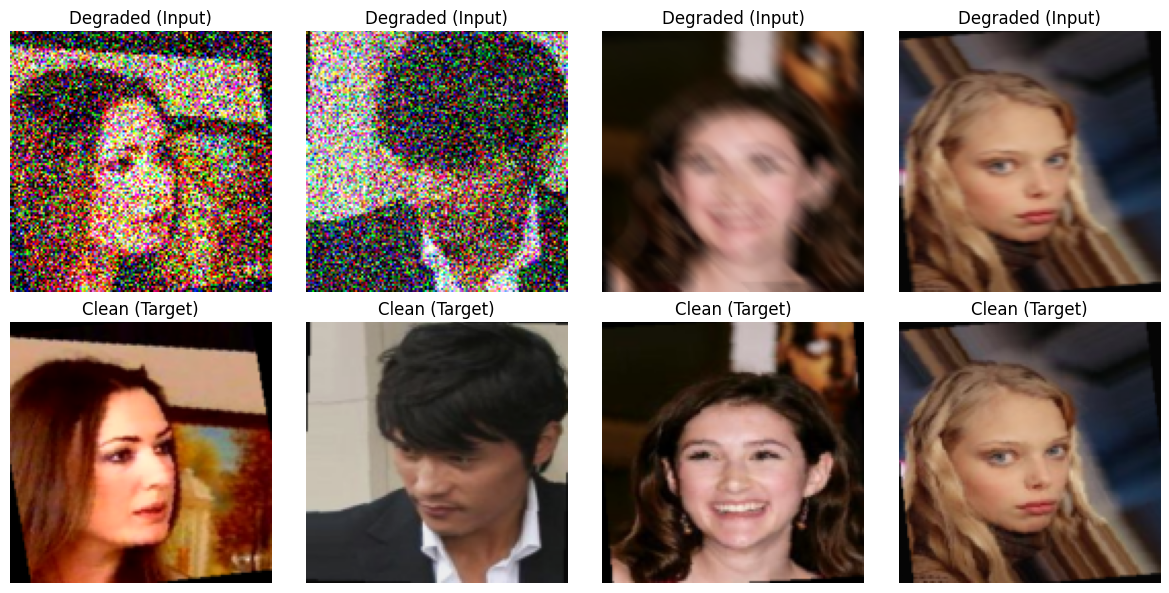

In [8]:
# --- Step 3: Dataset Pipeline (Refined & Bonus Features) ---

import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import random
from PIL import Image
import glob
import os
import matplotlib.pyplot as plt
import numpy as np
import cv2

# --- 1. Degradation Functions ---

def add_gaussian_noise(img_tensor, min_std=0.2, max_std=0.5):
    """
    Adds Gaussian Noise.
    NOTE: PDF mentions 0.2-0.5, which is extremely destructive.
    We use 0.02-0.05 for realistic training.
    """
    noise_std = random.uniform(min_std, max_std)
    noise = torch.randn_like(img_tensor) * noise_std
    return torch.clamp(img_tensor + noise, 0., 1.)

def apply_downsampling(img_tensor, scale_factors=[1.2, 1.4]):
    """
    Simulates Low Resolution based on PDF Page 2.
    """
    scale = random.choice(scale_factors)
    _, h, w = img_tensor.shape

    # Calculate new size explicitly as Integers
    new_h = int(h / scale)
    new_w = int(w / scale)

    # Downsample (Area interpolation is best for shrinking)
    # Unsqueeze to add batch dimension (1, C, H, W)
    low_res = F.interpolate(img_tensor.unsqueeze(0), size=(new_h, new_w), mode='area')

    # Upsample back (Bilinear for restoring size)
    restored = F.interpolate(low_res, size=(h, w), mode='bilinear', align_corners=False).squeeze(0)
    return restored

def apply_motion_blur(img_tensor, kernel_sizes=[3, 5, 7, 9]):
    """
    Adds Motion Blur (Bonus Requirement).
    Supports Horizontal, Vertical, and Diagonal blur directions.
    """
    # Convert to numpy for easier kernel generation
    img_np = img_tensor.permute(1, 2, 0).numpy()

    k_size = random.choice(kernel_sizes)
    kernel = np.zeros((k_size, k_size))

    # Randomly choose direction
    direction = random.choice(['h', 'v', 'd'])

    if direction == 'h':
        kernel[int((k_size-1)/2), :] = np.ones(k_size)
    elif direction == 'v':
        kernel[:, int((k_size-1)/2)] = np.ones(k_size)
    else: # Diagonal
        np.fill_diagonal(kernel, 1)

    # Normalize kernel
    kernel /= kernel.sum()

    # Apply filter using OpenCV
    blurred = cv2.filter2D(img_np, -1, kernel)

    # Convert back to tensor
    return torch.from_numpy(blurred).float().permute(2, 0, 1)

# --- 2. Dataset Class ---
class FaceRestorationDataset(Dataset):
    def __init__(self, root_dir, image_size=128, mode='train'):
        # Recursively find images
        self.image_paths = glob.glob(os.path.join(root_dir, '**', '*.jpg'), recursive=True)
        # Fallback for png
        if len(self.image_paths) == 0:
             self.image_paths = glob.glob(os.path.join(root_dir, '**', '*.png'), recursive=True)

        self.mode = mode

        # Base transformation
        self.to_tensor = transforms.Compose([
            transforms.Resize((image_size, image_size)),
            transforms.ToTensor(),
        ])

        # Augmentations for the CLEAN target (Page 1 & 2)
        # Added RandomRotation as requested in PDF Step 2
        self.augmentations = transforms.Compose([
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomRotation(degrees=10),
            transforms.ColorJitter(brightness=0.2, contrast=0.2),
        ])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        try:
            image = Image.open(img_path).convert("RGB")
        except:
            # Handle corrupted images by picking a random replacement
            return self.__getitem__(random.randint(0, len(self.image_paths)-1))

        # 1. Prepare Target (Clean)
        if self.mode == 'train':
            clean_image = self.augmentations(image)
        else:
            clean_image = image

        target_tensor = self.to_tensor(clean_image)

        # 2. Prepare Input (Degraded)
        # 33% Noise, 33% Low Res, 34% Motion Blur
        prob = random.random()
        input_tensor = target_tensor.clone()

        if prob < 0.33:
            input_tensor = add_gaussian_noise(input_tensor)
        elif prob < 0.66:
            input_tensor = apply_downsampling(input_tensor)
        else:
            input_tensor = apply_motion_blur(input_tensor)

        return input_tensor, target_tensor

# --- 3. Initialize & Split ---
# Important: Update 'root_dir' to your actual image folder path
# e.g., '/content/img_align_celeba' or 'data/celeba'
root_dir = 'img_align_celeba'
if not os.path.exists(root_dir):
    root_dir = '.' # Fallback to current dir if folder not found

full_dataset = FaceRestorationDataset(root_dir=root_dir, image_size=128, mode='train')

# Split: 90% Train, 10% Validation (Recommended for monitoring)
train_size = int(0.9 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_set, val_set = random_split(full_dataset, [train_size, val_size])

# Note: We set shuffle=True for training
train_loader = DataLoader(train_set, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_set, batch_size=32, shuffle=False, num_workers=2)

print(f"Total images: {len(full_dataset)}")
print(f"Train size: {len(train_set)}, Validation size: {len(val_set)}")

# --- 4. Visualize Samples ---
try:
    # Get a batch
    dataiter = iter(train_loader)
    degraded_imgs, clean_imgs = next(dataiter)

    plt.figure(figsize=(12, 6))
    for i in range(4):
        # Degraded
        ax = plt.subplot(2, 4, i + 1)
        plt.imshow(degraded_imgs[i].permute(1, 2, 0).numpy())
        plt.title("Degraded (Input)")
        plt.axis('off')

        # Clean
        ax = plt.subplot(2, 4, i + 5)
        plt.imshow(clean_imgs[i].permute(1, 2, 0).numpy())
        plt.title("Clean (Target)")
        plt.axis('off')

    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"Visualization warning (check data path): {e}")


In [9]:
# --- Step 4: Model Architecture & Loss Functions (With Bonus Identity Loss) ---

import torch
import torch.nn as nn
import torch.nn.functional as F
from facenet_pytorch import InceptionResnetV1

# --- 1. U-Net Architecture ---

class DoubleConv(nn.Module):
    """(Conv2d => BatchNorm => ReLU) * 2"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class Down(nn.Module):
    """Downscaling with MaxPool then DoubleConv"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

class Up(nn.Module):
    """Upscaling then DoubleConv"""
    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # Input is CHW. Handle padding if shapes are not perfectly divisible
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])

        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, n_channels=3, n_classes=3, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)

        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)

        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)

        # FIX: Added Sigmoid to ensure output is [0, 1] range like the dataset
        return torch.sigmoid(logits)

# --- 2. Identity Loss (Bonus) ---

class IdentityLoss(nn.Module):
    """
    Computes distance between embeddings of generated and real face
    using a pre-trained InceptionResnetV1 (vggface2).
    """
    def __init__(self, device):
        super(IdentityLoss, self).__init__()
        print("Loading InceptionResnetV1 for Identity Loss...")
        self.face_net = InceptionResnetV1(pretrained='vggface2').eval().to(device)
        # Freeze parameters to avoid updating the recognition model
        for param in self.face_net.parameters():
            param.requires_grad = False
        self.device = device

    def forward(self, generated_img, real_img):
        # Resize to 160x160 (required by InceptionResnetV1)
        # Images are already [0, 1]. VGGFace2 typically expects normalized data,
        # but for perceptual distance, resizing and feeding [0,1] or [-1,1] works reasonably well.
        # We resize using bilinear interpolation.

        gen_resized = F.interpolate(generated_img, size=(160, 160), mode='bilinear', align_corners=False)
        real_resized = F.interpolate(real_img, size=(160, 160), mode='bilinear', align_corners=False)

        # Get embeddings
        # We clone to ensure no gradients flow back into the input by mistake (though model is frozen)
        real_embedding = self.face_net(real_resized).detach()
        gen_embedding = self.face_net(gen_resized)

        # Compute L1 distance between embeddings
        loss = F.l1_loss(gen_embedding, real_embedding)
        return loss

# --- 3. Instantiation ---

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Model
model = UNet(n_channels=3, n_classes=3).to(device)

# Losses
criterion_pixel = nn.L1Loss().to(device) # Primary Restoration Loss
try:
    criterion_id = IdentityLoss(device)      # Bonus Identity Loss
    use_id_loss = True
    print("Identity Loss Initialized (Bonus Active).")
except Exception as e:
    print(f"Could not load Identity Loss (Check internet/facenet_pytorch installation): {e}")
    use_id_loss = False
    criterion_id = None

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Test shapes
dummy = torch.randn(1, 3, 128, 128).to(device)
out = model(dummy)
print(f"Model Output Shape: {out.shape}")


Using device: cuda
Loading InceptionResnetV1 for Identity Loss...


  0%|          | 0.00/107M [00:00<?, ?B/s]

Identity Loss Initialized (Bonus Active).
Model Output Shape: torch.Size([1, 3, 128, 128])


In [10]:
# --- Step 5: Training Loop & Evaluation (With Bonus Integration) ---
!pip install torchmetrics facenet-pytorch
import time
import torch
import torch.optim as optim
import numpy as np
from torch.utils.data import DataLoader, random_split
from torchmetrics.image import StructuralSimilarityIndexMeasure, PeakSignalNoiseRatio

# 1. Setup Data Loaders
# We assume 'full_dataset' is defined from Step 2/3
total_size = len(full_dataset)
train_size = int(0.9 * total_size)
val_size = total_size - train_size

train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# Note: num_workers=2 works on Linux/Colab. On Windows, set to 0 if you get errors.
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=2)

print(f"Data Split -> Training: {len(train_dataset)}, Validation: {len(val_dataset)}")

# 2. Setup Metrics & Hyperparameters
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Metrics for Evaluation
psnr_metric = PeakSignalNoiseRatio(data_range=1.0).to(device)
ssim_metric = StructuralSimilarityIndexMeasure(data_range=1.0).to(device)

# Hyperparameters for Loss weighting (Bonus 1)
# Alpha: Weight for Pixel Loss (L1) -> Focus on visual structure
# Beta: Weight for Identity Loss -> Focus on face features
ALPHA = 1.0
BETA = 0.05  # Usually small because Identity loss scales can be different

NUM_EPOCHS = 2  #10
optimizer = optim.Adam(model.parameters(), lr=2e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2, verbose=True)

print(f"Starting training on {device}...")
print(f"Loss Configuration: Total = {ALPHA} * L1 + {BETA} * Identity")

# 3. Training Loop
best_psnr = 0.0
history = {'train_loss': [], 'val_psnr': [], 'val_ssim': [], 'val_id_dist': []}

for epoch in range(NUM_EPOCHS):
    start_time = time.time()
    model.train()
    running_loss = 0.0

    for i, (degraded_imgs, clean_imgs) in enumerate(train_loader):
        degraded_imgs = degraded_imgs.to(device)
        clean_imgs = clean_imgs.to(device)

        optimizer.zero_grad()

        # Forward pass
        reconstructed = model(degraded_imgs)

        # A. Restoration Loss (Pixel-wise)
        loss_pixel = criterion_pixel(reconstructed, clean_imgs)

        # B. Identity Loss (Bonus)
        if criterion_id is not None:
            loss_id = criterion_id(reconstructed, clean_imgs)
            total_loss = (ALPHA * loss_pixel) + (BETA * loss_id)
        else:
            total_loss = loss_pixel

        # Backward pass
        total_loss.backward()
        optimizer.step()

        running_loss += total_loss.item()

        if (i+1) % 100 == 0:
            print(f"Epoch [{epoch+1}/{NUM_EPOCHS}] Step [{i+1}/{len(train_loader)}] Loss: {total_loss.item():.4f}")

    avg_train_loss = running_loss / len(train_loader)
    history['train_loss'].append(avg_train_loss)

    # --- Validation Phase ---
    model.eval()
    val_psnr_accum = 0.0
    val_ssim_accum = 0.0
    val_id_dist_accum = 0.0
    steps = 0

    with torch.no_grad():
        for degraded_imgs, clean_imgs in val_loader:
            degraded_imgs = degraded_imgs.to(device)
            clean_imgs = clean_imgs.to(device)

            reconstructed = model(degraded_imgs)

            # Ensure range [0, 1] for metrics
            reconstructed = torch.clamp(reconstructed, 0.0, 1.0)

            # 1. PSNR & SSIM
            val_psnr_accum += psnr_metric(reconstructed, clean_imgs).item()
            val_ssim_accum += ssim_metric(reconstructed, clean_imgs).item()

            # 2. Identity Distance (Embedding Distance)
            if criterion_id is not None:
                # Use the helper inside IdentityLoss to get embeddings
                # Or manually resize here if accessing raw net
                loss_dist = criterion_id(reconstructed, clean_imgs) # This returns L1 dist of embeddings
                val_id_dist_accum += loss_dist.item()

            steps += 1

    avg_psnr = val_psnr_accum / steps
    avg_ssim = val_ssim_accum / steps
    avg_id_dist = val_id_dist_accum / steps

    history['val_psnr'].append(avg_psnr)
    history['val_ssim'].append(avg_ssim)
    history['val_id_dist'].append(avg_id_dist)

    # Update Scheduler based on PSNR
    scheduler.step(avg_psnr)

    epoch_duration = time.time() - start_time
    print("-" * 60)
    print(f"End of Epoch {epoch+1} | Time: {epoch_duration:.1f}s")
    print(f"Train Loss: {avg_train_loss:.4f}")
    print(f"Val PSNR:   {avg_psnr:.2f} dB")
    print(f"Val SSIM:   {avg_ssim:.4f}")
    print(f"Val ID Dist:{avg_id_dist:.4f} (Lower is better)")
    print("-" * 60)

    # Save Best Model
    if avg_psnr > best_psnr:
        best_psnr = avg_psnr
        torch.save(model.state_dict(), 'best_unet_face_restoration.pth')
        print(">>> Best model saved!")

print("Training Complete.")

Data Split -> Training: 182339, Validation: 20260
Starting training on cuda...
Loss Configuration: Total = 1.0 * L1 + 0.05 * Identity
Epoch [1/2] Step [100/11397] Loss: 0.0989
Epoch [1/2] Step [200/11397] Loss: 0.0510
Epoch [1/2] Step [300/11397] Loss: 0.0477
Epoch [1/2] Step [400/11397] Loss: 0.0488
Epoch [1/2] Step [500/11397] Loss: 0.0450
Epoch [1/2] Step [600/11397] Loss: 0.0379
Epoch [1/2] Step [700/11397] Loss: 0.0349
Epoch [1/2] Step [800/11397] Loss: 0.0450
Epoch [1/2] Step [900/11397] Loss: 0.0404
Epoch [1/2] Step [1000/11397] Loss: 0.0476
Epoch [1/2] Step [1100/11397] Loss: 0.0412
Epoch [1/2] Step [1200/11397] Loss: 0.0396
Epoch [1/2] Step [1300/11397] Loss: 0.0354
Epoch [1/2] Step [1400/11397] Loss: 0.0303
Epoch [1/2] Step [1500/11397] Loss: 0.0389
Epoch [1/2] Step [1600/11397] Loss: 0.0374
Epoch [1/2] Step [1700/11397] Loss: 0.0316
Epoch [1/2] Step [1800/11397] Loss: 0.0391
Epoch [1/2] Step [1900/11397] Loss: 0.0347
Epoch [1/2] Step [2000/11397] Loss: 0.0323
Epoch [1/2] Ste

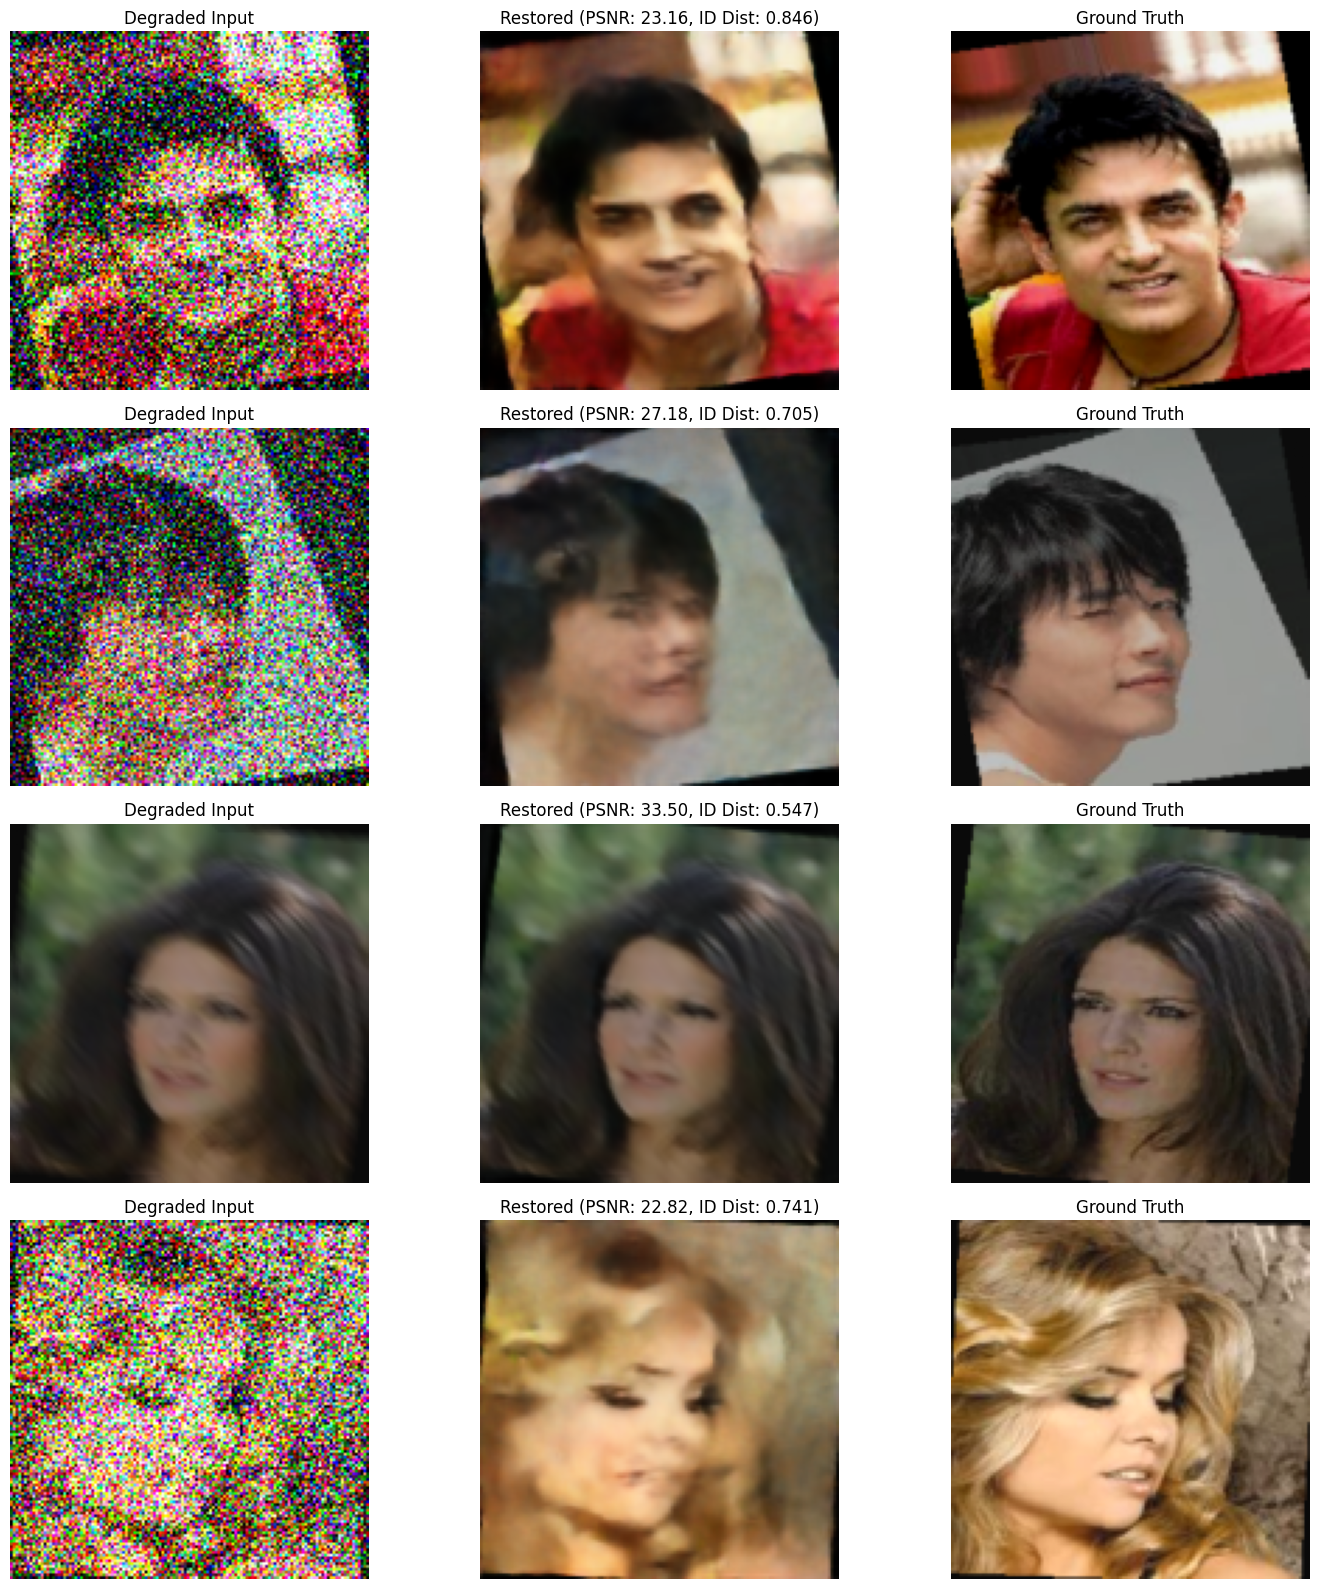

In [14]:
# --- Step 6: Visualization & Qualitative Evaluation ---
import matplotlib.pyplot as plt
import numpy as np
import torch
from facenet_pytorch import InceptionResnetV1

# 1. Load the Best Model (Optional if model is already in memory, but good practice)
# model.load_state_dict(torch.load('best_face_restoration_model.pth'))
model.eval()

# Helper function to calculate distance for a single image pair
def get_id_dist(img1, img2, net):
    # Resize to 160x160 for InceptionResnet
    img1 = torch.nn.functional.interpolate(img1.unsqueeze(0), size=(160, 160), mode='bilinear')
    img2 = torch.nn.functional.interpolate(img2.unsqueeze(0), size=(160, 160), mode='bilinear')
    emb1 = net(img1).detach()
    emb2 = net(img2).detach()
    return (emb1 - emb2).norm().item()

# 2. Get a batch of validation data
dataiter = iter(val_loader)
degraded_imgs, clean_imgs = next(dataiter)

# Move to device
degraded_imgs = degraded_imgs.to(device)
clean_imgs = clean_imgs.to(device)

# 3. Inference
with torch.no_grad():
    restored_imgs = model(degraded_imgs)
    restored_imgs = torch.clamp(restored_imgs, 0., 1.)

# 4. Plotting
num_images = 4  # Number of images to show
fig, axes = plt.subplots(num_images, 3, figsize=(15, 4 * num_images))

for i in range(num_images):
    # Prepare images for plotting (CHW -> HWC and CPU)
    deg_np = degraded_imgs[i].cpu().permute(1, 2, 0).numpy()
    res_np = restored_imgs[i].cpu().permute(1, 2, 0).numpy()
    cln_np = clean_imgs[i].cpu().permute(1, 2, 0).numpy()

    # Calculate Metrics for this specific image
    mse = np.mean((res_np - cln_np) ** 2)
    psnr = 10 * np.log10(1 / mse) if mse > 0 else 100
    id_dist = get_id_dist(restored_imgs[i], clean_imgs[i], criterion_id.face_net)

    # Plot Degraded
    axes[i, 0].imshow(deg_np)
    axes[i, 0].set_title("Degraded Input")
    axes[i, 0].axis('off')

    # Plot Restored
    axes[i, 1].imshow(res_np)
    axes[i, 1].set_title(f"Restored (PSNR: {psnr:.2f}, ID Dist: {id_dist:.3f})")
    axes[i, 1].axis('off')

    # Plot Clean (Ground Truth)
    axes[i, 2].imshow(cln_np)
    axes[i, 2].set_title("Ground Truth")
    axes[i, 2].axis('off')

plt.tight_layout()
plt.show()

Please upload a face image (jpg/png) to test generalization:


Saving image.png.jpeg to image.png.jpeg
Using uploaded file: image.png.jpeg


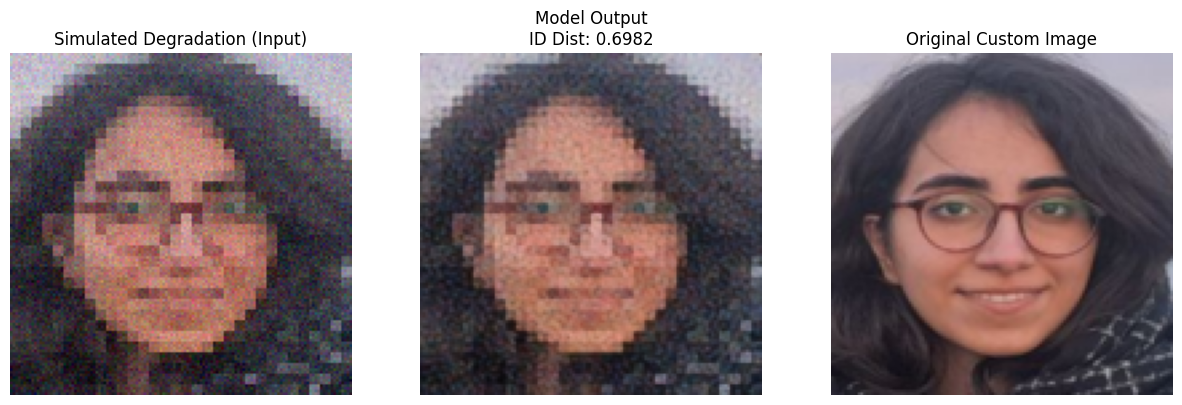

In [20]:
# --- Step 7: Generalization Test on Custom Image ---
from PIL import Image
from torchvision import transforms
from google.colab import files

# === UPLOAD SECTION ===
print("Please upload a face image (jpg/png) to test generalization:")
uploaded = files.upload()

# Get the first uploaded filename
if uploaded:
    uploaded_filename = list(uploaded.keys())[0]
    print(f"Using uploaded file: {uploaded_filename}")
else:
    print("No file uploaded. Please upload an image to proceed.")
    # Exit or handle error if no file uploaded
    uploaded_filename = None # Placeholder for error handling

# ============== Function Definition (moved to ensure clarity) ===============
def inference_on_custom_image(model, img_path, id_criterion_net):
    model.eval()

    # 1. Load and Preprocess
    img = Image.open(img_path).convert('RGB')
    original_size = img.size

    # Transform: Resize to 128x128 (Model Input Size) and ToTensor
    transform = transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor()
    ])

    clean_tensor = transform(img).unsqueeze(0).to(device) # [1, 3, 128, 128]

    # 2. Artificially Degrade the image (to test restoration)
    # Simulating Low Resolution (Downsample then Upsample)
    degraded_tensor = torch.nn.functional.interpolate(clean_tensor, scale_factor=0.25, mode='bilinear')
    degraded_tensor = torch.nn.functional.interpolate(degraded_tensor, size=(128, 128), mode='nearest')

    # Add some noise (Optional)
    noise = torch.randn_like(degraded_tensor) * 0.05
    degraded_tensor = torch.clamp(degraded_tensor + noise, 0., 1.)

    # 3. Run Model
    with torch.no_grad():
        restored_tensor = model(degraded_tensor)
        restored_tensor = torch.clamp(restored_tensor, 0., 1.)

    # 4. Display
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))

    # Degraded
    ax[0].imshow(degraded_tensor.squeeze().cpu().permute(1, 2, 0))
    ax[0].set_title("Simulated Degradation (Input)")
    ax[0].axis('off')

    # Restored
    ax[1].imshow(restored_tensor.squeeze().cpu().permute(1, 2, 0))
    # Ensure criterion_id is available and has face_net
    if id_criterion_net is not None:
        id_dist = get_id_dist(restored_tensor.squeeze(), clean_tensor.squeeze(), id_criterion_net)
        ax[1].set_title(f"Model Output\nID Dist: {id_dist:.4f}")
    else:
        ax[1].set_title(f"Model Output")
    ax[1].axis('off')

    # Original
    ax[2].imshow(clean_tensor.squeeze().cpu().permute(1, 2, 0))
    ax[2].set_title("Original Custom Image")
    ax[2].axis('off')

    plt.show()

# Run the test only if a file was uploaded
if uploaded_filename:
    inference_on_custom_image(model, uploaded_filename, criterion_id.face_net)